In [1]:
# This notebook trains LSTM model on the preprocessed data

#### Library

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set pandas to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Suppress pandas performance warnings
import warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

2025-02-23 13:59:22.604307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740344362.662134   14278 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740344362.681130   14278 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 13:59:22.735767: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Data Loading

In [3]:
# Load the data
df2021 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2021/merged_df_2021_cleaned.csv')
df2022 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2022/merged_df_2022_cleaned.csv')
df2023 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2023/merged_df_2023_cleaned.csv')
df2024 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2024/merged_df_2024_cleaned.csv')

In [4]:
# Concatenate the data
df = pd.concat([df2021, df2022, df2023, df2024], axis=0, ignore_index=True)

In [5]:
df.shape

(35076, 69)

In [6]:
df.head()

,datetime_,alberta_internal_load,forecast_alberta_internal_load,pool_price,forecast_pool_price,rolling_30day_avg_price,solar_generation,temp_calgary,temp_edmonton,temp_fortmc,wind_generation,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,day_of_month,week_of_month,month,year,is_winter,pool_price_lag_1,pool_price_lag_2,pool_price_lag_3,pool_price_lag_4,pool_price_lag_5,pool_price_lag_6,pool_price_lag_7,pool_price_lag_8,pool_price_lag_9,pool_price_lag_10,pool_price_lag_11,pool_price_lag_12,pool_price_lag_13,pool_price_lag_14,pool_price_lag_15,pool_price_lag_16,pool_price_lag_17,pool_price_lag_18,pool_price_lag_19,pool_price_lag_20,pool_price_lag_21,pool_price_lag_22,pool_price_lag_23,pool_price_lag_24,alberta_internal_load_lag_1,alberta_internal_load_lag_2,alberta_internal_load_lag_3,alberta_internal_load_lag_4,alberta_internal_load_lag_5,alberta_internal_load_lag_6,alberta_internal_load_lag_7,alberta_internal_load_lag_8,alberta_internal_load_lag_9,alberta_internal_load_lag_10,alberta_internal_load_lag_11,alberta_internal_load_lag_12,alberta_internal_load_lag_13,alberta_internal_load_lag_14,alberta_internal_load_lag_15,alberta_internal_load_lag_16,alberta_internal_load_lag_17,alberta_internal_load_lag_18,alberta_internal_load_lag_19,alberta_internal_load_lag_20,alberta_internal_load_lag_21,alberta_internal_load_lag_22,alberta_internal_load_lag_23,alberta_internal_load_lag_24
0,2021-01-01 00:00:00,9655.0,9718.0,29.92,32.91,38.45,0.0,-3.2,-5.8,-8.9,1470.686241,13.0,13.0,10.0,0,4,1,53,1,2021,1,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
1,2021-01-01 01:00:00,9513.0,9573.0,27.48,27.10,38.44,0.0,2.5,-7.8,-8.6,1525.467843,30.0,13.0,10.0,1,4,1,53,1,2021,1,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
2,2021-01-01 02:00:00,9437.0,9446.0,28.62,27.13,38.44,0.0,2.0,-10.4,-8.5,1535.146498,23.0,9.0,10.0,2,4,1,53,1,2021,1,27.48,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9513.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
3,2021-01-01 03:00:00,9376.0,9366.0,33.55,32.14,38.43,0.0,2.4,-11.9,-8.5,1484.051400,24.0,4.0,10.0,3,4,1,53,1,2021,1,28.62,27.48,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9437.0,9513.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
4,2021-01-01 04:00:00,9356.0,9357.0,35.36,35.64,38.43,0.0,2.4,-9.6,-8.9,1446.955595,22.0,4.0,10.0,4,4,1,53,1,2021,1,33.55,28.62,27.48,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9376.0,9437.0,9513.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0


In [7]:
df.columns

Index(['datetime_', 'alberta_internal_load', 'forecast_alberta_internal_load',
       'pool_price', 'forecast_pool_price', 'rolling_30day_avg_price',
       'solar_generation', 'temp_calgary', 'temp_edmonton', 'temp_fortmc',
       'wind_generation', 'ws_calgary', 'ws_edmonton', 'ws_fortmc',
       'hour_of_day', 'day_of_week', 'day_of_month', 'week_of_month', 'month',
       'year', 'is_winter', 'pool_price_lag_1', 'pool_price_lag_2',
       'pool_price_lag_3', 'pool_price_lag_4', 'pool_price_lag_5',
       'pool_price_lag_6', 'pool_price_lag_7', 'pool_price_lag_8',
       'pool_price_lag_9', 'pool_price_lag_10', 'pool_price_lag_11',
       'pool_price_lag_12', 'pool_price_lag_13', 'pool_price_lag_14',
       'pool_price_lag_15', 'pool_price_lag_16', 'pool_price_lag_17',
       'pool_price_lag_18', 'pool_price_lag_19', 'pool_price_lag_20',
       'pool_price_lag_21', 'pool_price_lag_22', 'pool_price_lag_23',
       'pool_price_lag_24', 'alberta_internal_load_lag_1',
       'alberta_in

In [8]:
# Check for missing values
df.isnull().sum().sort_values(ascending=False)

datetime_                         0
pool_price_lag_24                 0
alberta_internal_load_lag_6       0
alberta_internal_load_lag_5       0
alberta_internal_load_lag_4       0
alberta_internal_load_lag_3       0
alberta_internal_load_lag_2       0
alberta_internal_load_lag_1       0
pool_price_lag_23                 0
pool_price_lag_15                 0
pool_price_lag_22                 0
pool_price_lag_21                 0
pool_price_lag_20                 0
pool_price_lag_19                 0
pool_price_lag_18                 0
pool_price_lag_17                 0
alberta_internal_load_lag_7       0
alberta_internal_load_lag_8       0
alberta_internal_load_lag_9       0
alberta_internal_load_lag_10      0
alberta_internal_load_lag_11      0
alberta_internal_load_lag_12      0
alberta_internal_load_lag_13      0
alberta_internal_load_lag_14      0
alberta_internal_load_lag_15      0
alberta_internal_load_lag_16      0
alberta_internal_load_lag_17      0
alberta_internal_load_lag_18

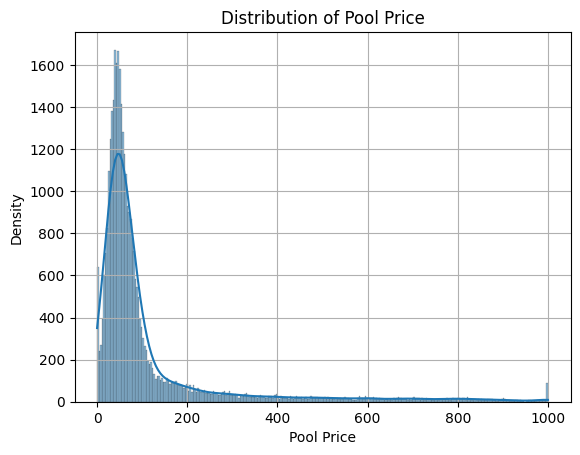

In [9]:
# Create a distribution plot of the 'pool_price' column
sns.histplot(df['pool_price'], kde=True)

# Add labels and title
plt.xlabel('Pool Price')
plt.ylabel('Density')
plt.title('Distribution of Pool Price')

# Show the plot
plt.grid()
plt.show()

In [10]:
# data filter to remove outliers
# df = df[df['pool_price'] <=200]

#### Train-Test split

In [11]:
# Convert datetime_ column to datetime type
df['datetime_'] = pd.to_datetime(df['datetime_'])

# Filter data for the first 11 months
train_data = df[df['datetime_'] < '2024-07-01']
test_data = df[df['datetime_'] >= '2024-07-01']

# Define independent variables (features) and target variable
X_train = train_data.drop(columns=['datetime_', 'pool_price'])
y_train = train_data['pool_price']
# Display the shapes of the training data
print(X_train.shape, y_train.shape)

# Define independent variables (features) and target variable
X_test = test_data.drop(columns=['datetime_', 'pool_price'])
y_test = test_data['pool_price']
# Display the shapes of the test data
print(X_test.shape, y_test.shape)

(30657, 67) (30657,)
(4419, 67) (4419,)


In [12]:
#Converting dataframe to numpy
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [13]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
#Reshaping the train and test data to pass into the LSTM layer
X_train = X_train.reshape((X_train.shape[0], 1, int(X_train.shape[1])))
X_test = X_test.reshape((X_test.shape[0], 1, int(X_test.shape[1])))

In [15]:
# Display the shapes of the training data
X_train.shape

(30657, 1, 67)

#### Model Training

In [16]:
#Baseline LSTM model
model = tf.keras.Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]))) #return_sequences=True,
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mae')

2025-02-23 13:59:37.571864: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/kevin/Downloads/BESS/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# display architecture of model shape of different layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       100,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,721 (432.50 KB)

 Trainable params: 110,721 (432.50 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=128, verbose=2, validation_split=0.2)

Epoch 1/20
192/192 - 17s - 90ms/step - loss: 81.8661 - val_loss: 26.4590
Epoch 2/20
192/192 - 6s - 30ms/step - loss: 37.1329 - val_loss: 26.9530
Epoch 3/20
192/192 - 5s - 25ms/step - loss: 31.8032 - val_loss: 30.9892
Epoch 4/20
192/192 - 5s - 26ms/step - loss: 30.0963 - val_loss: 30.5720
Epoch 5/20
192/192 - 5s - 24ms/step - loss: 29.1961 - val_loss: 27.6814
Epoch 6/20
192/192 - 5s - 24ms/step - loss: 28.3859 - val_loss: 27.5677
Epoch 7/20
192/192 - 6s - 30ms/step - loss: 27.9871 - val_loss: 25.9557
Epoch 8/20
192/192 - 8s - 39ms/step - loss: 27.6014 - val_loss: 27.8695
Epoch 9/20
192/192 - 8s - 41ms/step - loss: 27.2545 - val_loss: 27.7069
Epoch 10/20
192/192 - 8s - 42ms/step - loss: 27.1447 - val_loss: 26.1930
Epoch 11/20
192/192 - 6s - 32ms/step - loss: 26.8055 - val_loss: 25.7328
Epoch 12/20
192/192 - 6s - 31ms/step - loss: 26.6833 - val_loss: 23.9785
Epoch 13/20
192/192 - 5s - 25ms/step - loss: 26.3478 - val_loss: 23.7091
Epoch 14/20
192/192 - 5s - 25ms/step - loss: 26.2302 - val_

#### Model Performance Check

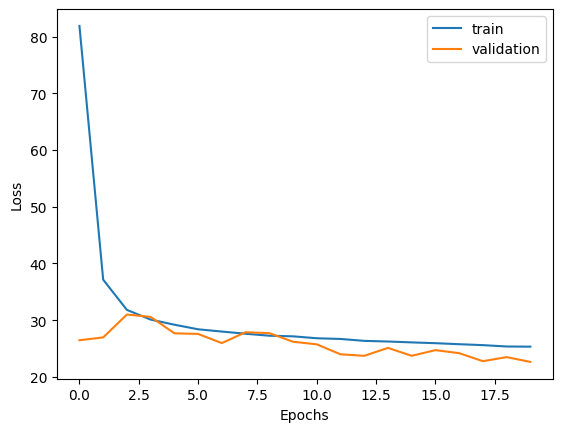

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
y_train_pred = model.predict(X_train)
y_train_pred = y_train_pred.reshape(-1, 1)
mae = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print('y_train shape:', y_train.shape)
print(f'Mean Absolute Error on the train set : {mae}')
print(f"R² Score train set: {r2}")

959/959 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step
y_train shape: (30657,)
Mean Absolute Error on the train set : 24.80163495983051
R² Score train set: 0.890778046310676


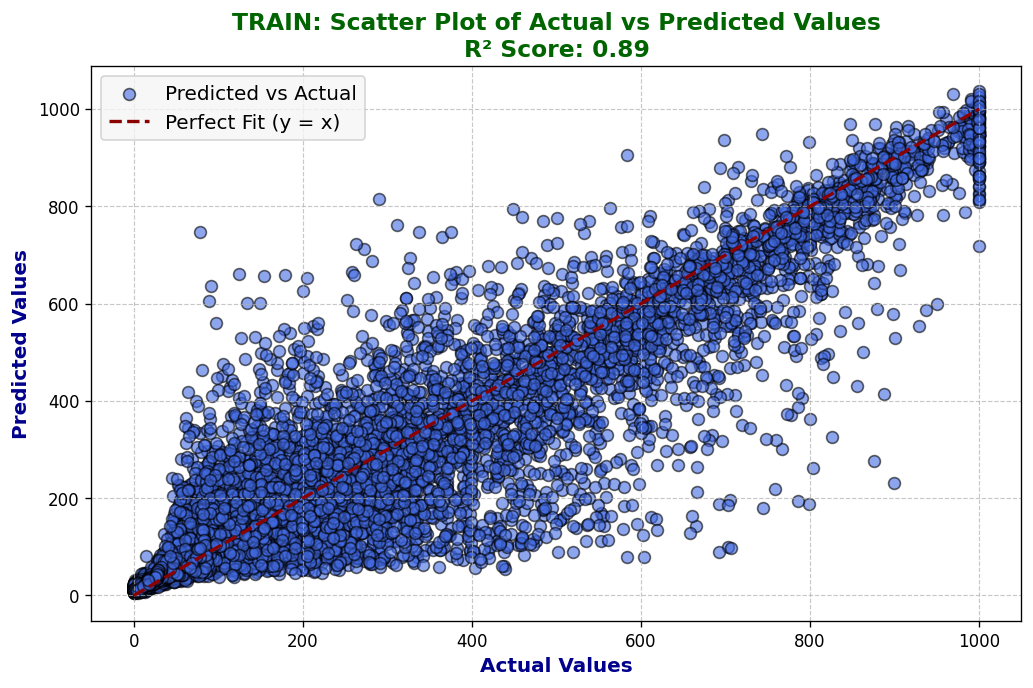

In [21]:
# Create a scatter plot with improved visibility
plt.figure(figsize=(10, 6), dpi=120)  # Higher DPI for sharper visualization

# Scatter plot with larger markers and better color contrast
plt.scatter(y_train, y_train_pred, alpha=0.6, color='royalblue', edgecolor='black', s=50, label='Predicted vs Actual')

# Add reference line (perfect predictions)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 
         color='darkred', linestyle='--', linewidth=2, label='Perfect Fit (y = x)')

# Improve labels and title for better readability
plt.xlabel('Actual Values', fontsize=12, fontweight='bold', color='darkblue')
plt.ylabel('Predicted Values', fontsize=12, fontweight='bold', color='darkblue')
plt.title(f'TRAIN: Scatter Plot of Actual vs Predicted Values\nR² Score: {r2:.2f}', 
          fontsize=14, fontweight='bold', color='darkgreen')

# Improve the legend for better clarity
plt.legend(fontsize=12, loc='upper left', frameon=True, facecolor='whitesmoke')

# Customize grid for improved visibility
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Enhance tick visibility
plt.xticks(fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')

# Show the plot
plt.show()


In [22]:
y_test_pred = model.predict(X_test)
y_test_pred = y_test_pred.reshape(-1, 1)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print('y_test_pred shape:', y_test_pred.shape)
print(f'Mean Absolute Error on the test set : {mae}')
print(f"R² Score test set: {r2}")

139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
y_test_pred shape: (4419, 1)
Mean Absolute Error on the test set : 26.873781136920428
R² Score test set: 0.858249084159159


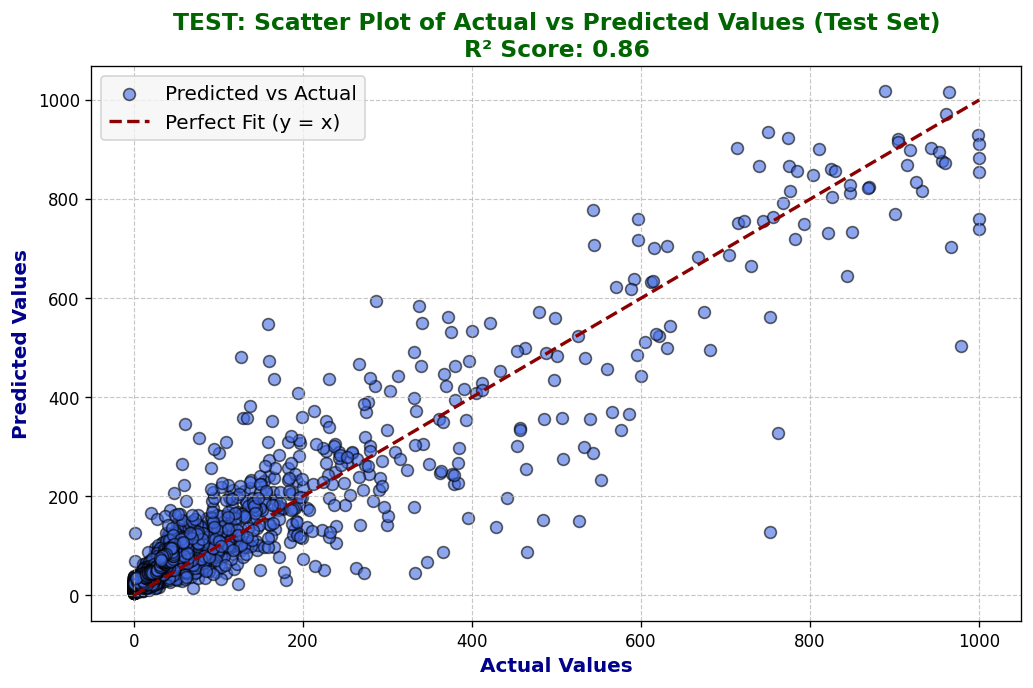

In [23]:
# Create a scatter plot for test data with improved visibility
plt.figure(figsize=(10, 6), dpi=120)  # Higher DPI for sharper visualization

# Scatter plot with larger markers and better color contrast
plt.scatter(y_test, y_test_pred, alpha=0.6, color='royalblue', edgecolor='black', s=50, label='Predicted vs Actual')

# Add reference line (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='darkred', linestyle='--', linewidth=2, label='Perfect Fit (y = x)')

# Improve labels and title for better readability
plt.xlabel('Actual Values', fontsize=12, fontweight='bold', color='darkblue')
plt.ylabel('Predicted Values', fontsize=12, fontweight='bold', color='darkblue')
plt.title(f'TEST: Scatter Plot of Actual vs Predicted Values (Test Set)\nR² Score: {r2:.2f}', 
          fontsize=14, fontweight='bold', color='darkgreen')

# Improve the legend for better clarity
plt.legend(fontsize=12, loc='upper left', frameon=True, facecolor='whitesmoke')

# Customize grid for improved visibility
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Enhance tick visibility
plt.xticks(fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')

# Show the plot
plt.show()


In [27]:
# Create a dataframe of the actual and predicted values
results_df = pd.DataFrame({'y_test':y_test, 'y_test_pred':y_test_pred.flatten()})
results_df.head()

,y_test,y_test_pred
0,14.69,30.394154
1,16.23,29.958067
2,15.77,29.290159
3,13.85,26.187063
4,13.58,25.971354


In [28]:
terget_df = results_df[results_df['y_test'] <= 200]

mae = mean_absolute_error(terget_df.y_test, terget_df.y_test_pred)
r2 = r2_score(terget_df.y_test, terget_df.y_test_pred)

print('terget_df shape:', terget_df.shape)
print(f'Mean Absolute Error on the test set : {mae}')
print(f"R² Score test set: {r2}")

terget_df shape: (4203, 2)
Mean Absolute Error on the test set : 22.843945044695186
R² Score test set: -0.01533625033751651


In [29]:
terget_df = results_df[results_df['y_test'] > 200]

mae = mean_absolute_error(terget_df.y_test, terget_df.y_test_pred)
r2 = r2_score(terget_df.y_test, terget_df.y_test_pred)

print('terget_df shape:', terget_df.shape)
print(f'Mean Absolute Error on the test set : {mae}')
print(f"R² Score test set: {r2}")

terget_df shape: (216, 2)
Mean Absolute Error on the test set : 105.2876750981366
R² Score test set: 0.6613833557270381
